# Imort Module

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import datetime as datetime
import os
from IPython.display import display, HTML
from math import isclose
from collections import Counter
import multiprocessing

# Network libary
from graph_tool.all import *
import networkx as nx
import networkit as nk

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import average_precision_score, precision_recall_curve

# Load train and test dataset

In [2]:
loaded = np.load("./tables/enron_staticlinkpred.npz",allow_pickle=True)
print(loaded.files)

edges_train = loaded["arr_0"]
labels_train = loaded["arr_1"]
edges_valid = loaded["arr_2"]
labels_valid = loaded["arr_3"]
edges_test = loaded["arr_4"]
labels_test = loaded["arr_5"]
df_node2cnt = pd.DataFrame(loaded["arr_6"])
df_node2cnt.columns = ["node","cnt"]
df_train_0 = pd.DataFrame(edges_train)
df_train_0[2] = labels_train
cond = df_train_0[2] == 1
df_train_1 = df_train_0.loc[cond].copy()
df_train = df_train_1[[0,1]].copy()
df_train.columns = ["source","target"]
df_train_0.columns = ["source","target","label"]

df_valid_0 = pd.DataFrame(edges_valid)
df_valid_0[2] = labels_valid
cond = df_valid_0[2] == 1
df_valid_1 = df_valid_0.loc[cond].copy()
df_valid = df_valid_1[[0,1]].copy()
df_valid.columns = ["source","target"]
df_valid_0.columns = ["source","target","label"]


df_test_0 = pd.DataFrame(edges_test)
df_test_0[2] = labels_test
cond = df_test_0[2] == 1
df_test_1 = df_test_0.loc[cond].copy()
df_test = df_test_1[[0,1]].copy()
df_test.columns = ["source","target"]
df_test_0.columns = ["source","target","label"]


['arr_0', 'arr_1', 'arr_2', 'arr_3', 'arr_4', 'arr_5', 'arr_6']


# Transductive => so we know that evey nodes are in the train set

In [3]:
out_tr,out_te = [],[]
    
uni_nodes = list(set(df_train["source"]))
uni_nodes.extend(list(set(df_train["target"])))
uni_nodes = list(set(uni_nodes))
    
node2index = dict()
for i in range(len(uni_nodes)):
    node2index.update({uni_nodes[i]:i})

for i in range(len(df_train)):
    source_index = node2index[df_train["source"].iloc[i]]
    target_index = node2index[df_train["target"].iloc[i]]
    out_tr.append([source_index,target_index])
        
for i in range(len(df_test)):
    source_index = node2index[df_test["source"].iloc[i]]
    target_index = node2index[df_test["target"].iloc[i]]
    out_te.append([source_index,target_index])
    
df_train_index = pd.DataFrame(out_tr)
df_test_index = pd.DataFrame(out_te)
df_train_index.columns = ["source","target"]
df_test_index.columns = ["source","target"]

# Networkx object

In [4]:
G = nx.Graph()
out_tr = []
for i in range(len(df_train_index)):
    s = df_train_index["source"].iloc[i]
    t = df_train_index["target"].iloc[i]
    out_tr.append((s, t))
    
out_te = []
for i in range(len(edges_test)):
    s = node2index[edges_test[i][0]]
    t = node2index[edges_test[i][1]]
    out_te.append((s, t))
    
G = nx.Graph()
G.add_edges_from(out_tr)


# Cacluate elementary methods

In [5]:
for kkk in range(1,5):
    # 1:"adamic", 2:"resource",3:"jaccard",4:"preferential"
    model_type = kkk

    if model_type == 1:
        preds = nx.adamic_adar_index(G, out_te)
        model_name = "adamic"
    elif model_type == 2:
        preds = nx.resource_allocation_index(G,out_te)
        model_name = "resource allocation"
    elif model_type == 3:
        preds = nx.jaccard_coefficient(G, out_te)
        model_name = "Jaccard Coefficient"
    elif model_type==4:
        preds = nx.preferential_attachment(G,out_te)
        model_name = "Preferential"
    prediction = []
    for u, v, p in preds:
        prediction.append(p)

    print(model_name)
    fpr, tpr, thresholds = metrics.roc_curve(labels_test, prediction)
    auc = metrics.auc(fpr, tpr)
    print(auc)
    # Data to plot precision - recall curve
    precision, recall, thresholds = precision_recall_curve(labels_test, prediction)
    # Use AUC function to calculate the area under the curve of precision recall curve
    auc_precision_recall = metrics.auc(recall, precision)
    print(auc_precision_recall)
    print("====")

adamic
0.8860603412338461
0.6708663527334671
====
resource allocation
0.8908167211616216
0.6806082813986878
====
Jaccard Coefficient
0.8520248517084295
0.5462805672312934
====
Preferential
0.7525213333936042
0.4813630636617093
====


# AU-ROC and AUC-PR

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


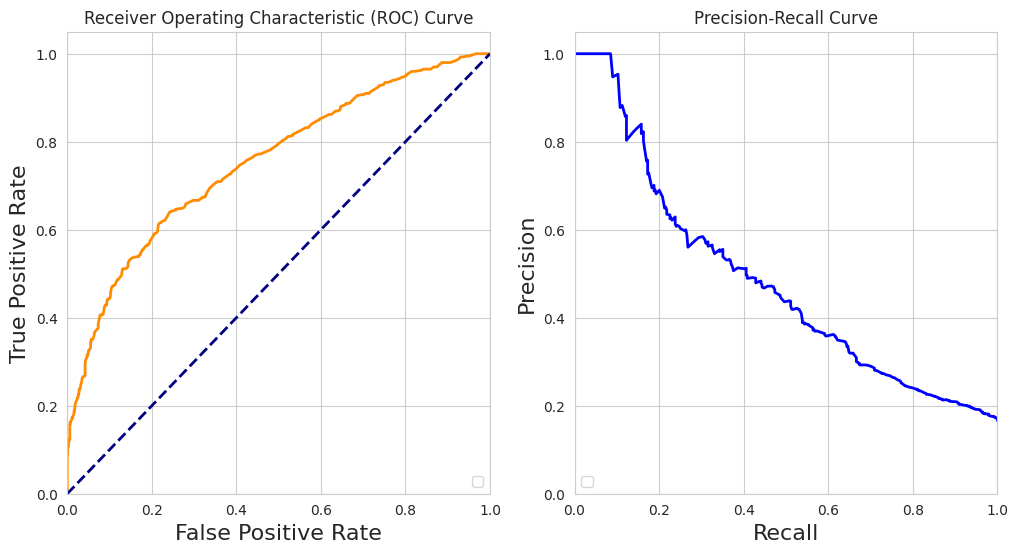

In [6]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',size=16)
plt.ylabel('True Positive Rate',size=16)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")


plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall',size=16)
plt.ylabel('Precision',size=16)
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

# Stochastic Block Model

In [7]:
# Create graph-tool object
g = Graph()

uni_nodes = list(set(df_train["source"]))
uni_nodes.extend(list(set(df_train["target"])))
uni_nodes = list(set(uni_nodes))
    
node2index = dict()
for i in range(len(uni_nodes)):
    node2index.update({uni_nodes[i]:i})
    

g.add_vertex(len(uni_nodes))
weight = g.new_edge_property("double")

# Put train data
for i in range(len(df_train)):
    source_index = node2index[df_train["source"].iloc[i]]
    target_index = node2index[df_train["target"].iloc[i]]
    e = g.add_edge(g.vertex(source_index),g.vertex(target_index))
    e = g.add_edge(g.vertex(target_index),g.vertex(source_index))
    weight[e] = 1  
    
g.edge_properties["weight"] = weight

# Infer SBM

In [8]:
%%time
state = minimize_blockmodel_dl(g,deg_corr=False)

CPU times: user 22 s, sys: 0 ns, total: 22 s
Wall time: 474 ms


# Collect edge_test probabilities

In [9]:
missing_edges = []
#for i in range(num_test):
for i in range(len(edges_test)):
    missing_edges.append((node2index[edges_test[i][0]],node2index[edges_test[i][1]]))

probs = [[] for _ in range(len(edges_test))]
def collect_edge_probs(s):
    for i in range(len(edges_test)):
        p1 = s.get_edges_prob([missing_edges[i]], entropy_args=dict(partition_dl=False))
        probs[i].append(p1)
        
def get_avg(p):
    p = np.array(p)
    pmax = p.max()
    p -= pmax
    return pmax + np.log(np.exp(p).mean())

In [10]:
%%time
# Now we collect the probabilities for exactly 100,000 sweeps
mcmc_equilibrate(state, force_niter=10, mcmc_args=dict(niter=10),
                    callback=collect_edge_probs,verbose=True)

niter:     1  count:    0  breaks:  0  min_S: 7474.5823  max_S: 7476.0397  S: 7476.0397  ΔS:      1.45741  moves:   591 
niter:     2  count:    0  breaks:  0  min_S: 7474.5823  max_S: 7477.8844  S: 7477.8844  ΔS:      1.84462  moves:   463 
niter:     3  count:    0  breaks:  0  min_S: 7473.4269  max_S: 7477.8844  S: 7473.4269  ΔS:     -4.45750  moves:   469 
niter:     4  count:    0  breaks:  0  min_S: 7473.4269  max_S: 7477.8844  S: 7474.4749  ΔS:      1.04807  moves:   701 
niter:     5  count:    0  breaks:  0  min_S: 7473.4269  max_S: 7485.1113  S: 7485.1113  ΔS:      10.6363  moves:   751 
niter:     6  count:    0  breaks:  0  min_S: 7473.4269  max_S: 7488.4208  S: 7488.4208  ΔS:      3.30950  moves:   632 
niter:     7  count:    0  breaks:  0  min_S: 7473.4269  max_S: 7488.4208  S: 7487.8235  ΔS:    -0.597231  moves:   756 
niter:     8  count:    0  breaks:  0  min_S: 7473.4269  max_S: 7495.2376  S: 7495.2376  ΔS:      7.41412  moves:   916 
niter:     9  count:    0  break

(7481.59164972676, 42999, 6501)

In [11]:
p_out = []
for i in range(len(probs)):
    p1 = get_avg(probs[i])
    p_out.append(p1)
p_sum = get_avg(p_out) + np.log(2)

prediction = []
for i in range(len(p_out)):
    prediction.append(np.exp(p_out[i] - p_sum))

# Evaluation

In [12]:
fpr, tpr, thresholds = metrics.roc_curve(labels_test, prediction)
auc = metrics.auc(fpr, tpr)
print(auc)
# Average precision score
average_precision = average_precision_score(labels_test, prediction)
print(average_precision)
# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(labels_test, prediction)
# Use AUC function to calculate the area under the curve of precision recall curve


0.858883807715682
0.5926014659305223
